In [1]:
# This tells matplotlib not to try opening a new window for each plot.
%matplotlib inline


import sys
sys.path.append('/usr/local/lib/python2.7/site-packages/')

import datetime
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import operator

from sklearn import preprocessing
from sklearn import metrics
from sklearn.grid_search import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.neighbors import KNeighborsRegressor
import csv
import time

from sklearn.naive_bayes import MultinomialNB,BernoulliNB,GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestClassifier as RFC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier 
from sklearn.ensemble import AdaBoostClassifier 
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import log_loss
from sklearn.qda import QDA

In [2]:
#running on a windows machine, change filepaths as needed

# Load the data - TRAINING
train_df = pd.read_csv('Data/train.csv')

In [31]:
# Explore the data
train_df.head()

,Dates,Category,Descript,DayOfWeek,PdDistrict,Resolution,Address,X,Y
0,2015-05-13 23:53:00,WARRANTS,WARRANT ARREST,Wednesday,NORTHERN,"ARREST, BOOKED",OAK ST / LAGUNA ST,-122.425892,37.774599
1,2015-05-13 23:53:00,OTHER OFFENSES,TRAFFIC VIOLATION ARREST,Wednesday,NORTHERN,"ARREST, BOOKED",OAK ST / LAGUNA ST,-122.425892,37.774599
2,2015-05-13 23:33:00,OTHER OFFENSES,TRAFFIC VIOLATION ARREST,Wednesday,NORTHERN,"ARREST, BOOKED",VANNESS AV / GREENWICH ST,-122.424363,37.800414
3,2015-05-13 23:30:00,LARCENY/THEFT,GRAND THEFT FROM LOCKED AUTO,Wednesday,NORTHERN,NONE,1500 Block of LOMBARD ST,-122.426995,37.800873
4,2015-05-13 23:30:00,LARCENY/THEFT,GRAND THEFT FROM LOCKED AUTO,Wednesday,PARK,NONE,100 Block of BRODERICK ST,-122.438738,37.771541


In [32]:
print "Number of categories: {}".format(len(train_df.Category.unique()))
print "Summary of X"
print train_df.X.describe()
print "Summary of Y"
print train_df.Y.describe()

Number of categories: 39
Summary of X
count    878049.000000
mean       -122.422616
std           0.030354
min        -122.513642
25%        -122.432952
50%        -122.416420
75%        -122.406959
max        -120.500000
Name: X, dtype: float64
Summary of Y
count    878049.000000
mean         37.771020
std           0.456893
min          37.707879
25%          37.752427
50%          37.775421
75%          37.784369
max          90.000000
Name: Y, dtype: float64


In [3]:
# Preprocess feature names - changing from names to numbers for easier processing.

# Split the street up into single locations
# For example, OAK ST / LAGUNA ST becomes OAK and LAGUNA
streets = [w for w in train_df['Address'].str.split()] 
p = []
for s in streets:
    p.append([i for i in s if i.isupper() and len(i) > 2])

train_df['street'] = p

# Preprocess Day of Week
le = preprocessing.LabelEncoder()
dow = le.fit_transform(train_df.DayOfWeek.values)
dow_orig = le.classes_

# Preprocess the full address
addr = le.fit_transform(train_df.Address)
addr_orig = le.classes_

# Preprocess the category
category = le.fit_transform(train_df.Category)
cat_orig = le.classes_

# Preprocess the police district
pdist = le.fit_transform(train_df.PdDistrict)
pd_orig = le.classes_

# Preprocess the street
street = le.fit_transform(train_df.street)
street_orig = le.classes_


In [4]:
# Update the original dataset with the new preprocessed data.
train_df['crime'] = category
train_df['addr'] = addr
train_df['dow'] = dow
train_df['pd'] = pdist
train_df['street'] = street

In [5]:
# Split the dates up into components - time, hour, month, etc
dates = pd.DatetimeIndex(train_df.Dates)

train_df['date'] = dates.date
train_df['time'] = dates.time
train_df['hour'] = dates.hour
train_df['minutes'] = dates.minute
train_df['month'] = dates.month
train_df['woy'] = dates.weekofyear
train_df['year'] = dates.year


holidays = [
            '2015-01-01','2015-01-19','2015-02-16','2015-05-25','2015-07-04','2015-09-07','2015-10-12','2015-11-11','2015-11-26','2015-11-27','2015-12-25',
            '2014-01-01','2014-01-20','2014-02-17','2014-05-26','2014-07-04','2014-09-01','2014-10-13','2014-11-11','2014-11-27','2014-11-28','2014-12-25',
            '2013-01-01','2013-01-21','2013-02-18','2013-05-27','2013-07-04','2013-09-02','2013-10-14','2013-11-11','2013-11-28','2013-11-29','2013-12-25',
            '2012-01-01','2012-01-16','2012-02-20','2012-05-28','2012-07-04','2012-09-03','2012-10-08','2012-11-11','2012-11-22','2012-11-23','2012-12-25',
            '2011-01-01','2011-01-17','2011-02-21','2011-05-30','2011-07-04','2011-09-05','2011-10-10','2011-11-11','2011-11-24','2011-11-25','2011-12-25',
            '2010-01-01','2010-01-18','2010-02-15','2010-05-31','2010-07-04','2010-09-06','2010-10-11','2010-11-11','2010-11-25','2010-11-26','2010-12-25',
            '2009-01-01','2009-01-19','2009-02-16','2009-05-25','2009-07-04','2009-09-07','2009-10-12','2009-11-11','2009-11-26','2009-11-27','2009-12-25',
            '2008-01-01','2008-01-21','2008-02-18','2008-05-26','2008-07-04','2008-09-01','2008-10-13','2008-11-11','2008-11-27','2008-11-28','2008-12-25',
            '2007-01-01','2007-01-15','2007-02-19','2007-05-28','2007-07-04','2007-09-03','2007-10-08','2007-11-11','2007-11-22','2007-11-23','2007-12-25',
            '2006-01-01','2006-01-16','2006-02-20','2006-05-29','2006-07-04','2006-09-04','2006-10-09','2006-11-11','2006-11-23','2006-11-24','2006-12-25',
            '2005-01-01','2005-01-17','2005-02-21','2005-05-30','2005-07-04','2005-09-05','2005-10-10','2005-11-11','2005-11-24','2005-11-25','2005-12-25',
            '2004-01-01','2004-01-19','2004-02-16','2004-05-31','2004-07-04','2004-09-06','2004-10-11','2004-11-11','2004-11-25','2004-11-26','2004-12-25'
           ]
hols = pd.DatetimeIndex(holidays).date

train_df['holiday'] = 0
train_df.ix[train_df['date'].isin(hols), 'holiday'] = 1



# Create a new feature - time of day
train_df.ix[train_df.hour <12,'time_of_day'] = "morning"
train_df.ix[train_df.hour >=12,'time_of_day'] = "midday"
train_df.ix[train_df.hour >14,'time_of_day'] = "afternoon"
train_df.ix[train_df.hour >18,'time_of_day'] = "night"

# Preprocess the time of day
le = preprocessing.LabelEncoder()
tod = le.fit_transform(train_df.time_of_day.values)
tod_orig = le.classes_

# Store it back into the training data
train_df['tod'] = tod

# Create a new feature - Season
train_df.ix[train_df.month == 12,'seas'] = "winter"
train_df.ix[train_df.month == 1,'seas'] = "winter"
train_df.ix[train_df.month == 2,'seas'] = "winter"
train_df.ix[train_df.month == 3,'seas'] = "spring"
train_df.ix[train_df.month == 4,'seas'] = "spring"
train_df.ix[train_df.month == 5,'seas'] = "spring"
train_df.ix[train_df.month == 6,'seas'] = "summer"
train_df.ix[train_df.month == 7,'seas'] = "summer"
train_df.ix[train_df.month == 8,'seas'] = "summer"
train_df.ix[train_df.month == 9,'seas'] = "fall"
train_df.ix[train_df.month == 10,'seas'] = "fall"
train_df.ix[train_df.month == 11,'seas'] = "fall"

# Preprocess the season
le = preprocessing.LabelEncoder()
season = le.fit_transform(train_df.seas.values)
season_orig = le.classes_

# Store it back into the training data
train_df['season'] = season

In [6]:
# Create a new subset of data
train_df_new = train_df[['date','holiday','year','month', 'woy', 'hour','minutes','tod', 'dow','season', 'pd','addr','street', 'X','Y','crime']]
train_df_new.head()

,date,holiday,year,month,woy,hour,minutes,tod,dow,season,pd,addr,street,X,Y,crime
0,2015-05-13,0,2015,5,20,23,53,3,6,1,4,19790,10076,-122.425892,37.774599,37
1,2015-05-13,0,2015,5,20,23,53,3,6,1,4,19790,10076,-122.425892,37.774599,21
2,2015-05-13,0,2015,5,20,23,33,3,6,1,4,22697,13528,-122.424363,37.800414,21
3,2015-05-13,0,2015,5,20,23,30,3,6,1,4,4266,8634,-122.426995,37.800873,16
4,2015-05-13,0,2015,5,20,23,30,3,6,1,5,1843,3183,-122.438738,37.771541,16


In [29]:
'''EVAN NEW STUFF'''

#Create binarized dummy arrays
dum_days = pd.get_dummies(train_df.DayOfWeek)
print "Days as dummy"
print dum_days.shape

dum_pds = pd.get_dummies(train_df.PdDistrict)
print "\nDistrict as dummy"
print dum_pds.shape

dum_street = pd.get_dummies(train_df.street)
print "\Street as dummy"
print dum_street.shape

dum_hours = pd.get_dummies(train_df_new.hour)
print "\nHours as dummy"
print dum_hours.shape

dum_season = pd.get_dummies(train_df.seas)
print "\nSeason as dummy"
print dum_season.shape

dum_tod = pd.get_dummies(train_df.time_of_day)
print "\ToD as dummy"
print dum_tod.shape

# TRIAL 1
#dum_cols = pd.concat([dum_days, dum_pds], axis=1)
#Acc = 0.219265788288
#LogLoss = 2.61856923059

#TRIAL 2
dum_cols = pd.concat([dum_days, dum_pds, dum_hours, dum_season, dum_street], axis=1)
#0.222293171569
#2.58553584854

#TRIAL 3
#dum_cols = pd.concat([dum_days, dum_pds, dum_tod, dum_season], axis=1)
#0.221415173405
#2.60544577822

#TRIAL 4
#dum_cols = pd.concat([dum_days, dum_pds, dum_hours, dum_season], axis=1)
#0.222293171569
#2.58553584854

print "\Combined:"
print dum_cols.shape
print dum_cols.head()

Days as dummy
(878049, 7)

District as dummy
(878049, 10)


MemoryError: 

In [24]:
'''EVAN NEW STUFF'''
#train_2 = pd.concat([train_df_new.crime, train_df_new.X, train_df_new.Y, dum_cols], axis=1)
#train_2 = pd.concat([train_df_new.crime, dum_cols], axis=1)

#Optimizing non-dummy cols on Trail2
train_2 = pd.concat([train_df_new.crime, dum_cols], axis=1)
#0.222298872856
#2.58583128457

print train_2.shape
print train_2.head()

(878049, 46)
   crime  Friday  Monday  Saturday  Sunday  Thursday  Tuesday  Wednesday  \
0     37       0       0         0       0         0        0          1   
1     21       0       0         0       0         0        0          1   
2     21       0       0         0       0         0        0          1   
3     16       0       0         0       0         0        0          1   
4     16       0       0         0       0         0        0          1   

   BAYVIEW  CENTRAL   ...    18  19  20  21  22  23  fall  spring  summer  \
0        0        0   ...     0   0   0   0   0   1     0       1       0   
1        0        0   ...     0   0   0   0   0   1     0       1       0   
2        0        0   ...     0   0   0   0   0   1     0       1       0   
3        0        0   ...     0   0   0   0   0   1     0       1       0   
4        0        0   ...     0   0   0   0   0   1     0       1       0   

   winter  
0       0  
1       0  
2       0  
3       0  
4      

In [25]:
'''EVAN NEW STUFF'''
# Create the DEV set from the TRAIN set - 20% dev, 80% train
DEV_SIZE = 0.20
np.random.seed(0)
msk = np.random.rand(len(train_2)) < DEV_SIZE

dev = train_2[msk]
dev_labels = np.array(dev.crime)
dev.drop('crime',1,inplace=True)

train = train_2[~msk]  # inverse of boolean mask
train_labels = np.array(train.crime)
train.drop('crime',1,inplace=True)

print "Dev: " + str(dev.shape)
print "Train: " + str(train.shape)
print train_labels.shape
print dev_labels.shape

/home/simon/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/simon/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Dev: (175399, 45)
Train: (702650, 45)
(702650,)
(175399,)


/home/simon/anaconda/lib/python2.7/site-packages/matplotlib/axes/_subplots.py:69: MatplotlibDeprecationWarning: The use of 0 (which ends up being the _last_ sub-plot) is deprecated in 1.4 and will raise an error in 1.5
  mplDeprecation)


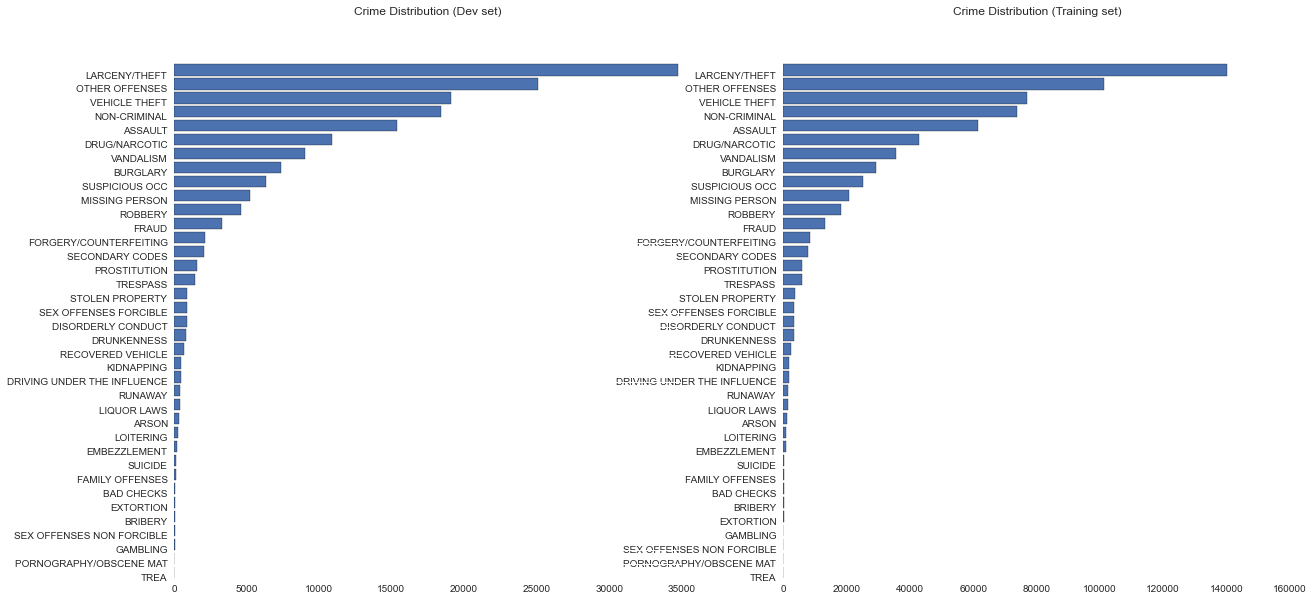

In [44]:
# make sure dev and train datasets have similar distribution for outcome variable
plt.figure(figsize=(20,10))
labels = [train_labels, dev_labels]
titles = ["Training set","Dev set"]
for i in [0,1]:
    plt.subplot(1,2,i)
    hist = np.histogram(labels[i], bins=range(38))
    ix = np.argsort(hist[0])
    plt.barh(range(37),hist[0][ix])
    x = plt.yticks(range(37),cat_orig[ix])
    ttl = "Crime Distribution ({})".format(titles[i])
    plt.title(ttl)

In [26]:
'''EVAN NEW STUFF'''
# Create the features
features = [i for i in train.columns]
print features
print train[features][:5]

['Friday', 'Monday', 'Saturday', 'Sunday', 'Thursday', 'Tuesday', 'Wednesday', 'BAYVIEW', 'CENTRAL', 'INGLESIDE', 'MISSION', 'NORTHERN', 'PARK', 'RICHMOND', 'SOUTHERN', 'TARAVAL', 'TENDERLOIN', 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 'fall', 'spring', 'summer', 'winter']
   Friday  Monday  Saturday  Sunday  Thursday  Tuesday  Wednesday  BAYVIEW  \
0       0       0         0       0         0        0          1        0   
1       0       0         0       0         0        0          1        0   
2       0       0         0       0         0        0          1        0   
3       0       0         0       0         0        0          1        0   
4       0       0         0       0         0        0          1        0   

   CENTRAL  INGLESIDE   ...    18  19  20  21  22  23  fall  spring  summer  \
0        0          0   ...     0   0   0   0   0   1     0       1       0   
1        0          0   ...     0   0   0   0   0   1  

In [27]:
##################################
# Model 1: Bernoulli Naive Bayes #
##################################

model = BernoulliNB()
model.fit(train[features], train_labels)
preds = model.predict(dev[features])
print "Accuracy: ", metrics.accuracy_score(dev_labels, preds)

llpreds = np.array(model.predict_proba(dev[features]))
print "Log Loss: " ,log_loss(dev_labels, llpreds)

Accuracy:  0.222281768995
Log Loss:  2.58547567689


In [16]:
##################################
# Model 2: Gaussian Naive Bayes  #
##################################
model = GaussianNB()
model.fit(train[features], train_labels)

preds = model.predict(dev[features])
print "Accuracy: ", metrics.accuracy_score(dev_labels, preds)

llpreds = np.array(model.predict_proba(dev[features]))
print "Log Loss: " ,log_loss(dev_labels, llpreds)

[22 22 22 ...,  0 22 23]
Accuracy:  0.00347208364928
Log Loss:  27.0256720059


In [28]:
##################################
# Model 8: Logistic Regression   #
##################################
model = LogisticRegression()
model.fit(train[features],train_labels)

preds = model.predict(dev[features])
print "Accuracy: ", metrics.accuracy_score(dev_labels, preds)

llpreds = np.array(model.predict_proba(dev[features]))
print "Log Loss: " ,log_loss(dev_labels, llpreds)

Accuracy:  0.221945393075
Log Loss:  2.58289780761


In [18]:
##################################
# Model 3: K Nearest Neighbours  #
##################################

knn = KNeighborsRegressor()
start_time = time.time()
knn.fit(train[features], train_labels)
print 'Train time = %.2f' %(time.time() - start_time)
start_time = time.time()

llpreds = np.array(knn.predict_proba(dev[features]))
print "Log Loss: " ,log_loss(dev_labels, llpreds)

print 'Prediction time = %.2f' %(time.time() - start_time)

 Train time = 21.41
Accuracy:  -0.165007314753


AttributeError: 'KNeighborsRegressor' object has no attribute 'predict_proba'

In [19]:
##################################
# Model 4: Decision Tree         #
##################################

dt = DecisionTreeClassifier(criterion="entropy", splitter="best", random_state=0)
dt.fit(train[features], train_labels)

preds = dt.predict(dev[features])
print "Accuracy: ", metrics.accuracy_score(dev_labels, preds)

llpreds = np.array(dt.predict_proba(dev[features]))
print "Log Loss: " ,log_loss(dev_labels, llpreds)


Accuracy:  0.249186141312
Log Loss:  25.0030119152


In [ ]:
##################################
# Model 5: Random Forest         #
##################################
rfc = RandomForestClassifier()
rfc.fit(train[features],train_labels)

preds = rfc.predict(dev[features])
print "Accuracy: ", metrics.accuracy_score(dev_labels, preds)

llpreds = np.array(rfc.predict_proba(dev[features]))
print "Log Loss: " ,log_loss(dev_labels, llpreds)

In [16]:
##################################
# Model 6: Ada Boost Tree        #
##################################
abc = AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=1), n_estimators=100, learning_rate=0.1)

abc.fit(train[features], train_labels)
preds = abc.predict(dev[features])
print "Accuracy: ", metrics.accuracy_score(dev_labels, preds)

llpreds = np.array(abc.predict_proba(dev[features]))
print "Log Loss: " ,log_loss(dev_labels, llpreds)


Accuracy (adaboost with decision trees): 0.208017149471


In [53]:
####################################
# Model 7: Gradient Boosting Trees #
####################################

params = {'n_estimators': 1000, 'max_depth': 6,
        'learning_rate': 0.01, 'alpha':0.001}

clf = GradientBoostingRegressor(**params).fit(train_data, train_labels)

clf.fit(train[features], train_labels)
preds = clf.predict(dev[features])
print "Accuracy: ", metrics.accuracy_score(dev_labels, preds)

llpreds = np.array(clf.predict_proba(dev[features]))
print "Log Loss: " ,log_loss(dev_labels, llpreds)


ValueError: Can't handle mix of multiclass and continuous